In [2]:
require(data.table)
require(dplyr)
require(tidyverse)
require(phyloseq)
require(ggplot2)
require(vegan)
require(RColorBrewer)
require(metacoder)
options(repr.plot.width=20, repr.plot.height=15)

In [3]:
ps<-readRDS(file = "/work/pi_sarah_gignouxwolfsohn_uml_edu/caroline/RDS/ps.rds")
#removing any taxa that don't show up in any samples to speed up the process
ps <- prune_taxa(taxa_sums(ps) > 0, ps)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 107292 taxa and 93 samples ]
sample_data() Sample Data:       [ 93 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 107292 taxa by 6 taxonomic ranks ]

In [4]:
#normalizing ps by converting rawcounts into relative abundances
#so samples with more reads wont be over represented
#using ps bc only to the count data (OTU table), while preserving the rest of the object
ps_norm = transform_sample_counts(ps, function(x) 1E6 * x / sum(x))
ps_norm

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 107292 taxa and 93 samples ]
sample_data() Sample Data:       [ 93 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 107292 taxa by 6 taxonomic ranks ]

In [5]:
#isolate just bacteria
ps_norm_bac=subset_taxa(ps_norm, Kingdom=="Bacteria")
ps_norm_bac
#remove chloroplast order
ps_norm_nochlo=subset_taxa(ps_norm_bac, Order!="Chloroplast")

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 103625 taxa and 93 samples ]
sample_data() Sample Data:       [ 93 samples by 107891 sample variables ]
tax_table()   Taxonomy Table:    [ 103625 taxa by 6 taxonomic ranks ]

In [6]:
# convert the sample_data() within a phyloseq object to a vegan compatible data object
pssd2veg <- function(ps_norm_nochlo) {
  sd_nochlo <- sample_data(ps_norm_nochlo)
  return(as(sd_nochlo,"data.frame"))
}

#using phyloseq nmds plot no chloroplast
sample_nochlo <- pssd2veg(ps_norm_nochlo)

In [7]:
# convert the otu_table() within a phyloseq object to a vegan compatible data object
psotu2veg <- function(ps_norm_nochlo) {
  otu_nochlo <- otu_table(ps_norm_nochlo)
  if (taxa_are_rows(otu_nochlo)) {
    otu_nochlo <- t(otu_nochlo)
  }
  return(as(otu_nochlo, "matrix"))
}

# Extract normalized OTU matrix and sample data
otu_nochlo <- psotu2veg(ps_norm_nochlo)

In [8]:
#cleaning up sample_norm to only be metadata
sample_clean <- sample_nochlo[, c("Health_Status", "colony", "Date_16S", "double_band", "date_sampled", "transect", "species", "MonthYear")]


In [9]:
# 1. create proper Date variable
sample_clean$MonthYearDate <- as.Date(
  paste0("01 ", sample_clean$MonthYear),
  format = "%d %b %Y"
)

# 2. reorder MonthYear as a factor in chronological order
sample_clean$MonthYear <- factor(
  sample_clean$MonthYear,
  levels = unique(sample_clean$MonthYear[order(sample_clean$MonthYearDate)])
)

In [10]:
# Should return TRUE
all(rownames(sample_clean) == rownames(otu_nochlo))

[1] TRUE

## vegan 

### vegan diversity

In [19]:
shannon <- diversity(otu_nochlo)
head(shannon)

012024_BEL_CBC_T1_557_SSID 012024_BEL_CBC_T1_563_PSTR 
                  4.632698                   5.925497 
012024_BEL_CBC_T2_601_OFAV 012024_BEL_CBC_T2_605_SSID 
                  4.545674                   6.181548 
012024_BEL_CBC_T3_627_PAST 012024_BEL_CBC_T3_631_MCAV 
                  5.879691                   3.938413

In [21]:
simpson <- diversity(otu_nochlo, index= "simpson")
head(simpson)

012024_BEL_CBC_T1_557_SSID 012024_BEL_CBC_T1_563_PSTR 
                 0.9531636                  0.9960937 
012024_BEL_CBC_T2_601_OFAV 012024_BEL_CBC_T2_605_SSID 
                 0.9793889                  0.9809798 
012024_BEL_CBC_T3_627_PAST 012024_BEL_CBC_T3_631_MCAV 
                 0.9768766                  0.9309603

In [22]:
#species richness
specnumber(otu_nochlo)

012024_BEL_CBC_T1_557_SSID  012024_BEL_CBC_T1_563_PSTR 
                       1471                         643 
 012024_BEL_CBC_T2_601_OFAV  012024_BEL_CBC_T2_605_SSID 
                        844                        2989 
 012024_BEL_CBC_T3_627_PAST  012024_BEL_CBC_T3_631_MCAV 
                       6318                         507 
 012024_BEL_CBC_T3_633_MCAV  012024_BEL_CBC_T3_637_SSID 
                        920                         649 
 012024_BEL_CBC_T4_661_PSTR  012024_BEL_CBC_T4_663_PSTR 
                        852                         773 
 022024_BEL_CBC_T1_775_OANN  022024_BEL_CBC_T1_776_PSTR 
                        940                         250 
 022024_BEL_CBC_T2_804_OFAV  022024_BEL_CBC_T2_814_MCAV 
                       3709                        1772 
 022024_BEL_CBC_T3_851_PSTR  022024_BEL_CBC_T4_874_OFAV 
                        454                        2192 
 022024_BEL_CBC_T4_875_MCAV  042024_BEL_CBC_T1_927_PSTR 
                        437                         527 
042024_BEL_CBC_T2_1014_OFAV 042024_BEL_CBC_T2_1018_PAST 
                       3107                        2276 
042024_BEL_CBC_T2_1026_OFAV 042024_BEL_CBC_T2_1144_MCAV 
                       4105                        1825 
042024_BEL_CBC_T4_1046_PSTR 042024_BEL_CBC_T4_1047_MCAV 
                        272                        1626 
   052022_BEL_CBC_T1_2_SSID    052022_BEL_CBC_T2_1_SSID 
                       1263                        3272 
  052022_BEL_CBC_T2_71_OFAV    052022_BEL_CBC_T2_9_PAST 
                       2291                        3866 
  052022_BEL_CBC_T3_11_PAST   052022_BEL_CBC_T3_13_MCAV 
                        343                        3093 
  052022_BEL_CBC_T3_19_MCAV   052022_BEL_CBC_T3_66_OFAV 
                       1113                         346 
   052022_BEL_CBC_T3_8_PAST   062019_BEL_CBC_T1_21_PAST 
                        242                         305 
  062019_BEL_CBC_T1_22_MCAV   062019_BEL_CBC_T2_18_MCAV 
                       1284                         482 
   062019_BEL_CBC_T3_1_MCAV 062024_BEL_CBC_T1_1347_OANN 
                        137                        1822 
062024_BEL_CBC_T1_1353_MCAV 062024_BEL_CBC_T2_1375_SSID 
                       3829                        8736 
062024_BEL_CBC_T2_1396_MCAV 062024_BEL_CBC_T3_1415_MCAV 
                       5716                         464 
062024_BEL_CBC_T3_1433_PSTR 062024_BEL_CBC_T3_1439_OFAV 
                       1655                        1840 
062024_BEL_CBC_T3_1442_OFAV 082024_BEL_CBC_T1_1479_PAST 
                        471                        2943 
082024_BEL_CBC_T1_1482_OANN 082024_BEL_CBC_T2_1510_PAST 
                       1317                        4271 
082024_BEL_CBC_T3_1554_OANN 082024_BEL_CBC_T3_1558_MCAV 
                       4184                        2434 
082024_BEL_CBC_T3_1560_PSTR 082024_BEL_CBC_T3_1561_MCAV 
                       1430                        2574 
082024_BEL_CBC_T3_1562_OFAV 082024_BEL_CBC_T4_1606_PSTR 
                       2505                         699 
082024_BEL_CBC_T4_1607_PSTR 082024_BEL_CBC_T4_1609_OFAV 
                       1344                        1262 
 092023_BEL_CBC_T1_171_PAST  092023_BEL_CBC_T1_175_PAST 
                       2198                        2271 
 092023_BEL_CBC_T2_174_SSID  092023_BEL_CBC_T2_181_PAST 
                       2050                        2757 
 092023_BEL_CBC_T2_184_MCAV  092023_BEL_CBC_T3_171_OFAV 
                       1900                        5154 
 092023_BEL_CBC_T3_173_OFAV  092023_BEL_CBC_T3_178_PAST 
                       6327                        1269 
 092023_BEL_CBC_T3_195_PSTR   092023_BEL_CBC_T4_92_PSTR 
                        590                         912 
  092023_BEL_CBC_T4_94_MCAV   102019_BEL_CBC_T1_29_PSTR 
                       2693                         301 
 112023_BEL_CBC_T1_276_MCAV  112023_BEL_CBC_T2_304_OFAV 
                       1074                        1332 
 112023_BEL

In [24]:
length(rowSums(otu_nochlo>0))

[1] 93

### vegan clusters

In [29]:
require(vegan)

In [36]:
head(otu_nochlo)
head(sample_clean)

,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTGTGTTAAGTCGGATGTGAAAGCCCAGGGCTCAACCTTGGAATTGCATCCGATACTGGCACGCTAGAGTGCAGTAGAGGGAGGTGGAATTTCCGGTGTAGCGGTGAAATGCGTAGAGATCGGAAGGAACACCAGTGGCGAAGGCGGCCTCCTGGACTGACACTGACGCTGAGGTGCGAAAGCGTGGGG,GCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGTGCGTAGGTGGCATGACAAGTCACTTGTGAAATCTCCGAGCTTAACTCGGAACGGTCAAGTGATACTGTTGTGCTAGAGTGCGGGAAGGGCAGCTGGAATTCTTGGTGTAGCGGTGAAATGCGTAGATATCAAGAGGAACACCGGAGGCGAAGGCGAGTTGCTAGACCGACACTGACGCTGAGGCACGAAAGCCAGGGG,GCAAGCGTTATCCGGATTTACTGGGTTTAAAGAGTGCGTAGGCGGCTTCTTAAGTCAGTGGTGAAAGCTTAGCGCTTAACGCTAGAAGTGCCACTGATACTGGGAAGCTTGAGTCAAGAAGAGGTAAGCAGAATTCATAGTGTAGCAGTGAAATGCTTAGATACTATGAGGAATACCAACAGCGAAGGCAGCTTACTGGTCTTGTACTGACGTTGAGGCACGAAAGCGTGGGT,GCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGACGTGCAAGTCTGGTGTGAAAGACCGCAGCTCAACTGCGGGCACGCGCTGGAAACTGTATGTCTTGAATCCTTGAGGGGGAACTGGAATTCCTGGTGTAGGGGTGAAATCTGTAGATATCAGGAAGAACACCGGTGGCGAAGGCGAGTTCCTGGCAAGTGATTGACGCTGAGGCGCGAAAGCGTGGGG,⋯,GCAAGCGTTATCCGGAATGACTGGGTGTAAAGAGCATGTAGGCGGGGATGCAAGTCAGATGTGAAATCTTAAGGCTCAACCTTATTGAGCATCTGAAACTGTGTTTCTTGAGTACTGGAGAGGAAAGTGGAATTCCTAGTGTAGCGGTGAAATGCGTAGATATTAGGAGGAACACCAGTGGCGAAGGCGGCTTTCTGGACAGTAACTGACGCTGAGATGCGAAAGTGTGGGT,GCAAGCGTTATTCGGAATTACTGGGCGTAAAGGGCGCGCAGGCGGCCCGTTAAGTGAGAAGTGAAAGCCCCGGGCTCAACCCGGGAATTGCTTCTCATACTGGCAGGCTAGAGGATGGGAGAGGAAAATGGAATTCCCGGTGTAGCGGTGAAATGCGTAGAGATCGGGAGGAACACCAGTGGCGAAGGCGGTTTTCTGGACCATTACTGACGCTGAGGCGCGAAAGCGTGGGG,GCAAGCGTTGTTCGGAATTATTGGGCGTAAAGGGGAGGTAGGTGGTCTTGTTTGTCGAGGGTGAAATCCCGGGGCTCAACCCCGGAAGTGCCTTCGAAACGGCAAGACTAGAGTATCGGAGAGGGCTGTGGAATTCCCGGTGTAGCGGTGAAATGCGTAGAGATCGGGAGGAACACCAGAGGCGAAGGCGGCAGCCTGGACGATTACTGACACTAAACTCCGAAAGCGTGGGG,GCAAGCGTTGTTCGGATTCATTGGGTGTAAAGGGTATGTAGGTGTCCTGCCAAGTCTTTCTTGAAATACTCTGGCTCAACCAGAGACCCGGGAGAGAAACTGGCAGGATTGAGTACTGGAGAGGAAAGCGGAATTCCCGGTGTAAGGGTGAAATCTGTAGATATCGGGAGGAACACCAGTGGCGAAAGCGGCTTTCTGGCCAGATACTGACACTGAAATACGAAAGCAAGGGG,GGCATGCTAAGTCTCATGTGAAATCTCCCGGCTCAACTGGGAGGGGTCATGGGAAACTGGCAAGCTGGAGGGCAGCAGAGGAAAGCGGAATTCCGGGAGTAGTGGTGGAATGCGTAGATACCCGGAGGAACACCAGAGGCGAAGGCGGCTTTCTGGGCTGTACCTGACGCTGAGACACGAAAGCGTGGGGAGCAAACCGGATTAGAAACCCCGGTAGTCCAACCTGTCTCTTATACACATCTCCGAGCCCACGAGACGC,GGTGCGGTAAGTGAGGTGTGAAATCCCCCGGCTCAACCGAGGAATTGCGCTTCATACTGCCGTGCTAGAGGGAGACAGAGGTAAGCGGAACTGATGGTGGAGCGGTGAAATGCGTTGATATCATCAGGAACACCGGTGGCGAAAGCGGCTTACTGGGTCTCTTCTGACGCTGAGGCACGAAAGCTAGGGTAGCGAACGGGATTAGATACCCGGGTAGTCC,GCAAGCGTTATTCGGAATTATTGGGCGTAAAGGGTCTGTAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATCCTGACACTCAGATGCGACAGCGTGGGG,GGTGAGT

,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,MonthYearDate
,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<date>
012024_BEL_CBC_T1_557_SSID,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,2024-01-01
012024_BEL_CBC_T1_563_PSTR,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,2024-01-01
012024_BEL_CBC_T2_601_OFAV,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,2024-01-01
012024_BEL_CBC_T2_605_SSID,Healthy,2_99,3_10_2025,y,012024,T2,SSID,Jan 2024,2024-01-01
012024_BEL_CBC_T3_627_PAST,Healthy,3_34,3_10_2025,y,012024,T3,PAST,Jan 2024,2024-01-01
012024_BEL_CBC_T3_631_MCAV,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,2024-01-01


In [51]:
# merge otu and sam_clean by sample ID
otu_nochlo$SampleID <- rownames(otu_nochlo)
sample_clean$SampleID <- rownames(sample_clean)

otu_merged <- merge(otu_nochlo, sample_clean, by = "SampleID",
                    all = TRUE, sort = FALSE)
rownames(otu_merged) <- otu_merged$SampleID
otu_merged$SampleID <- NULL
otu_nochlo$SampleID <- NULL

class(otu_merged)
head(otu_merged)

[1] "data.frame"

,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATAGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGAGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,GCAAGCGTTGTTCGGAATTACTGGGCGTAAAGGGCGTGTAGGCGGATTATCAAGTTAGGGGTGAAATCCCGGGGCTCAACCTCGGCACTGCCTTTAAGACTGATAATCTAGAGTATGTGAGGGGATAATGGAATACCTAGTGTAGAGGTGAAATTCGTAGATATTAGGTGGAACACCAGTGGCGAAGGCGATTATCTGGCACATTACTGACGCTGAGGCGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGTGCGTAGGCGGCCTTTTAAGTTGGATGTGAAAGCCCCGGGCTTAACCTGGGAACGGCATCCAAAACTGGGAGGCTCGAGTGCGGAAGAGGAGTGTGGAATTTCCTGTGTAGCGGTGAAATGCGTAGATATAGGAAAGAACACCAGTGGCGAAGGCGACACTCTGGTCTGACACTGACGCTGAGGTACGAAAGCGTGGGG,TCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTTTGCTAAGTCAGATGTGAAATCCCTGGGCTTAACCTAGGAACTGCATTTGAAACTAGCAAGCTAGAGTATGGTAGAGGTGGGTGGAATTTCAGGTGTAGCGGTGGAATGCGTAGAGATCTGAAGGAACATCAGTGGCGAAGGCGGCTCACTGGGCCATCACTGACGCTGAGGTGCGAAAGCGTGGGT,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCATGCAGGTGGTTTGTTAAGTCAGATGTGAAAGCCCGGGGCTCAACCTCGGAATTGCATTTGAAACTGGCAGACTAGAGTACTGTAGAGGGGGGTAGAATTTCAGGTGTAGCGGTGAAATGCGTAGAGATCTGAAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACAGATACTGACACTCAGATGCGAAAGCGTGGGG,GCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCGCGTAGGCGGTGTGTTAAGTCGGATGTGAAAGCCCAGGGCTCAACCTTGGAATTGCATCCGATACTGGCACGCTAGAGTGCAGTAGAGGGAGGTGGAATTTCCGGTGTAGCGGTGAAATGCGTAGAGATCGGAAGGAACACCAGTGGCGAAGGCGGCCTCCTGGACTGACACTGACGCTGAGGTGCGAAAGCGTGGGG,GCAAGCGTTGTTCGGATTTACTGGGCGTAAAGGGTGCGTAGGTGGCATGACAAGTCACTTGTGAAATCTCCGAGCTTAACTCGGAACGGTCAAGTGATACTGTTGTGCTAGAGTGCGGGAAGGGCAGCTGGAATTCTTGGTGTAGCGGTGAAATGCGTAGATATCAAGAGGAACACCGGAGGCGAAGGCGAGTTGCTAGACCGACACTGACGCTGAGGCACGAAAGCCAGGGG,GCAAGCGTTATCCGGATTTACTGGGTTTAAAGAGTGCGTAGGCGGCTTCTTAAGTCAGTGGTGAAAGCTTAGCGCTTAACGCTAGAAGTGCCACTGATACTGGGAAGCTTGAGTCAAGAAGAGGTAAGCAGAATTCATAGTGTAGCAGTGAAATGCTTAGATACTATGAGGAATACCAACAGCGAAGGCAGCTTACTGGTCTTGTACTGACGTTGAGGCACGAAAGCGTGGGT,GCGAGCGTTGTTCGGAATTATTGGGCGTAAAGGGCGCGTAGGCGGACGTGCAAGTCTGGTGTGAAAGACCGCAGCTCAACTGCGGGCACGCGCTGGAAACTGTATGTCTTGAATCCTTGAGGGGGAACTGGAATTCCTGGTGTAGGGGTGAAATCTGTAGATATCAGGAAGAACACCGGTGGCGAAGGCGAGTTCCTGGCAAGTGATTGACGCTGAGGCGCGAAAGCGTGGGG,⋯,GCGAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGCTAGATGTGAAAGCCCCGGGCTCAACCTGGGATGGTCATTTAGAACTGGCAGACTAGAGTCTTGGAGAGGGGAGTGGAATTCCAGGTGTAGCGGTGAAATGCGTAGATATCTGGAGGAACATCAGTGGCGAAGGCGACTCCCTGGAAAAAGACTGACGCTCATGTGCGAAAGTGTGGGT,Health_Status,colony,Date_16S,double_band,date_sampled,transect,species,MonthYear,MonthYearDate
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>,<date>
012024_BEL_CBC_T1_557_SSID,4865.3199,40000.00000,269.36027,521.8855,101.01010,2971.3805,0.00000,92.59259,151.51515,0.00000,⋯,0,Healthy,1_3,3_4_2025,y,012024,T1,SSID,Jan 2024,2024-01-01
012024_BEL_CBC_T1_563_PSTR,3138.2492,789.75808,1143.07091,0.0000,0.00000,1018.3723,0.00000,0.00000,0.00000,2784.93640,⋯,0,Healthy,1_12,3_6_2025,,012024,T1,PSTR,Jan 2024,2024-01-01
012024_BEL_CBC_T2_601_OFAV,1445.8334,12229.55868,27737.03578,626.3538,56194.37847,2834.2511,0.00000,114.83154,66644.04833,25116.78889,⋯,0,Healthy,2_79,3_4_2025,,012024,T2,OFAV,Jan 2024,2024-01-01
012024_BEL_CBC_T2_605_SSID,837.9009,29175.94182,23.16777,287.6664,27.02906,992.3527,272.22127,25.09841,40.54359,71.43395,⋯,0,Healthy,2_99,3_10_2025,y,012024,T2,SSID,Jan 2024,2024-01-01
012024_BEL_CBC_T3_627_PAST,658.8073,37.02014,66.48514,0.0000,18.88782,105.0163,0.00000,67.24066,51.37488,40.79770,⋯,0,Healthy,3_34,3_10_2025,y,012024,T3,PAST,Jan 2024,2024-01-01
012024_BEL_CBC_T3_631_MCAV,780.4597,282.94613,14.14731,0.0000,25.93673,294.7356,11.78942,119044.86818,3131.27050,2362.60018,⋯,0,Healthy,3_21,3_4_2025,,012024,T3,MCAV,Jan 2024,2024-01-01


In [52]:
nrow(otu_nochlo)
nrow(otu_merged)
all(rownames(otu_nochlo) == rownames(otu_merged))

[1] 93

[1] 93

[1] TRUE

In [53]:
# Hellinger transform
ord <- decostand(otu_nochlo, method = "hellinger")

In [55]:
str(otu_merged$species)
table(otu_merged$species)

 chr [1:93] "SSID" "PSTR" "OFAV" "SSID" "PAST" "MCAV" "MCAV" "SSID" "PSTR" ...



MCAV OANN OFAV PAST PSTR SSID 
  26    4   16   18   17   12 

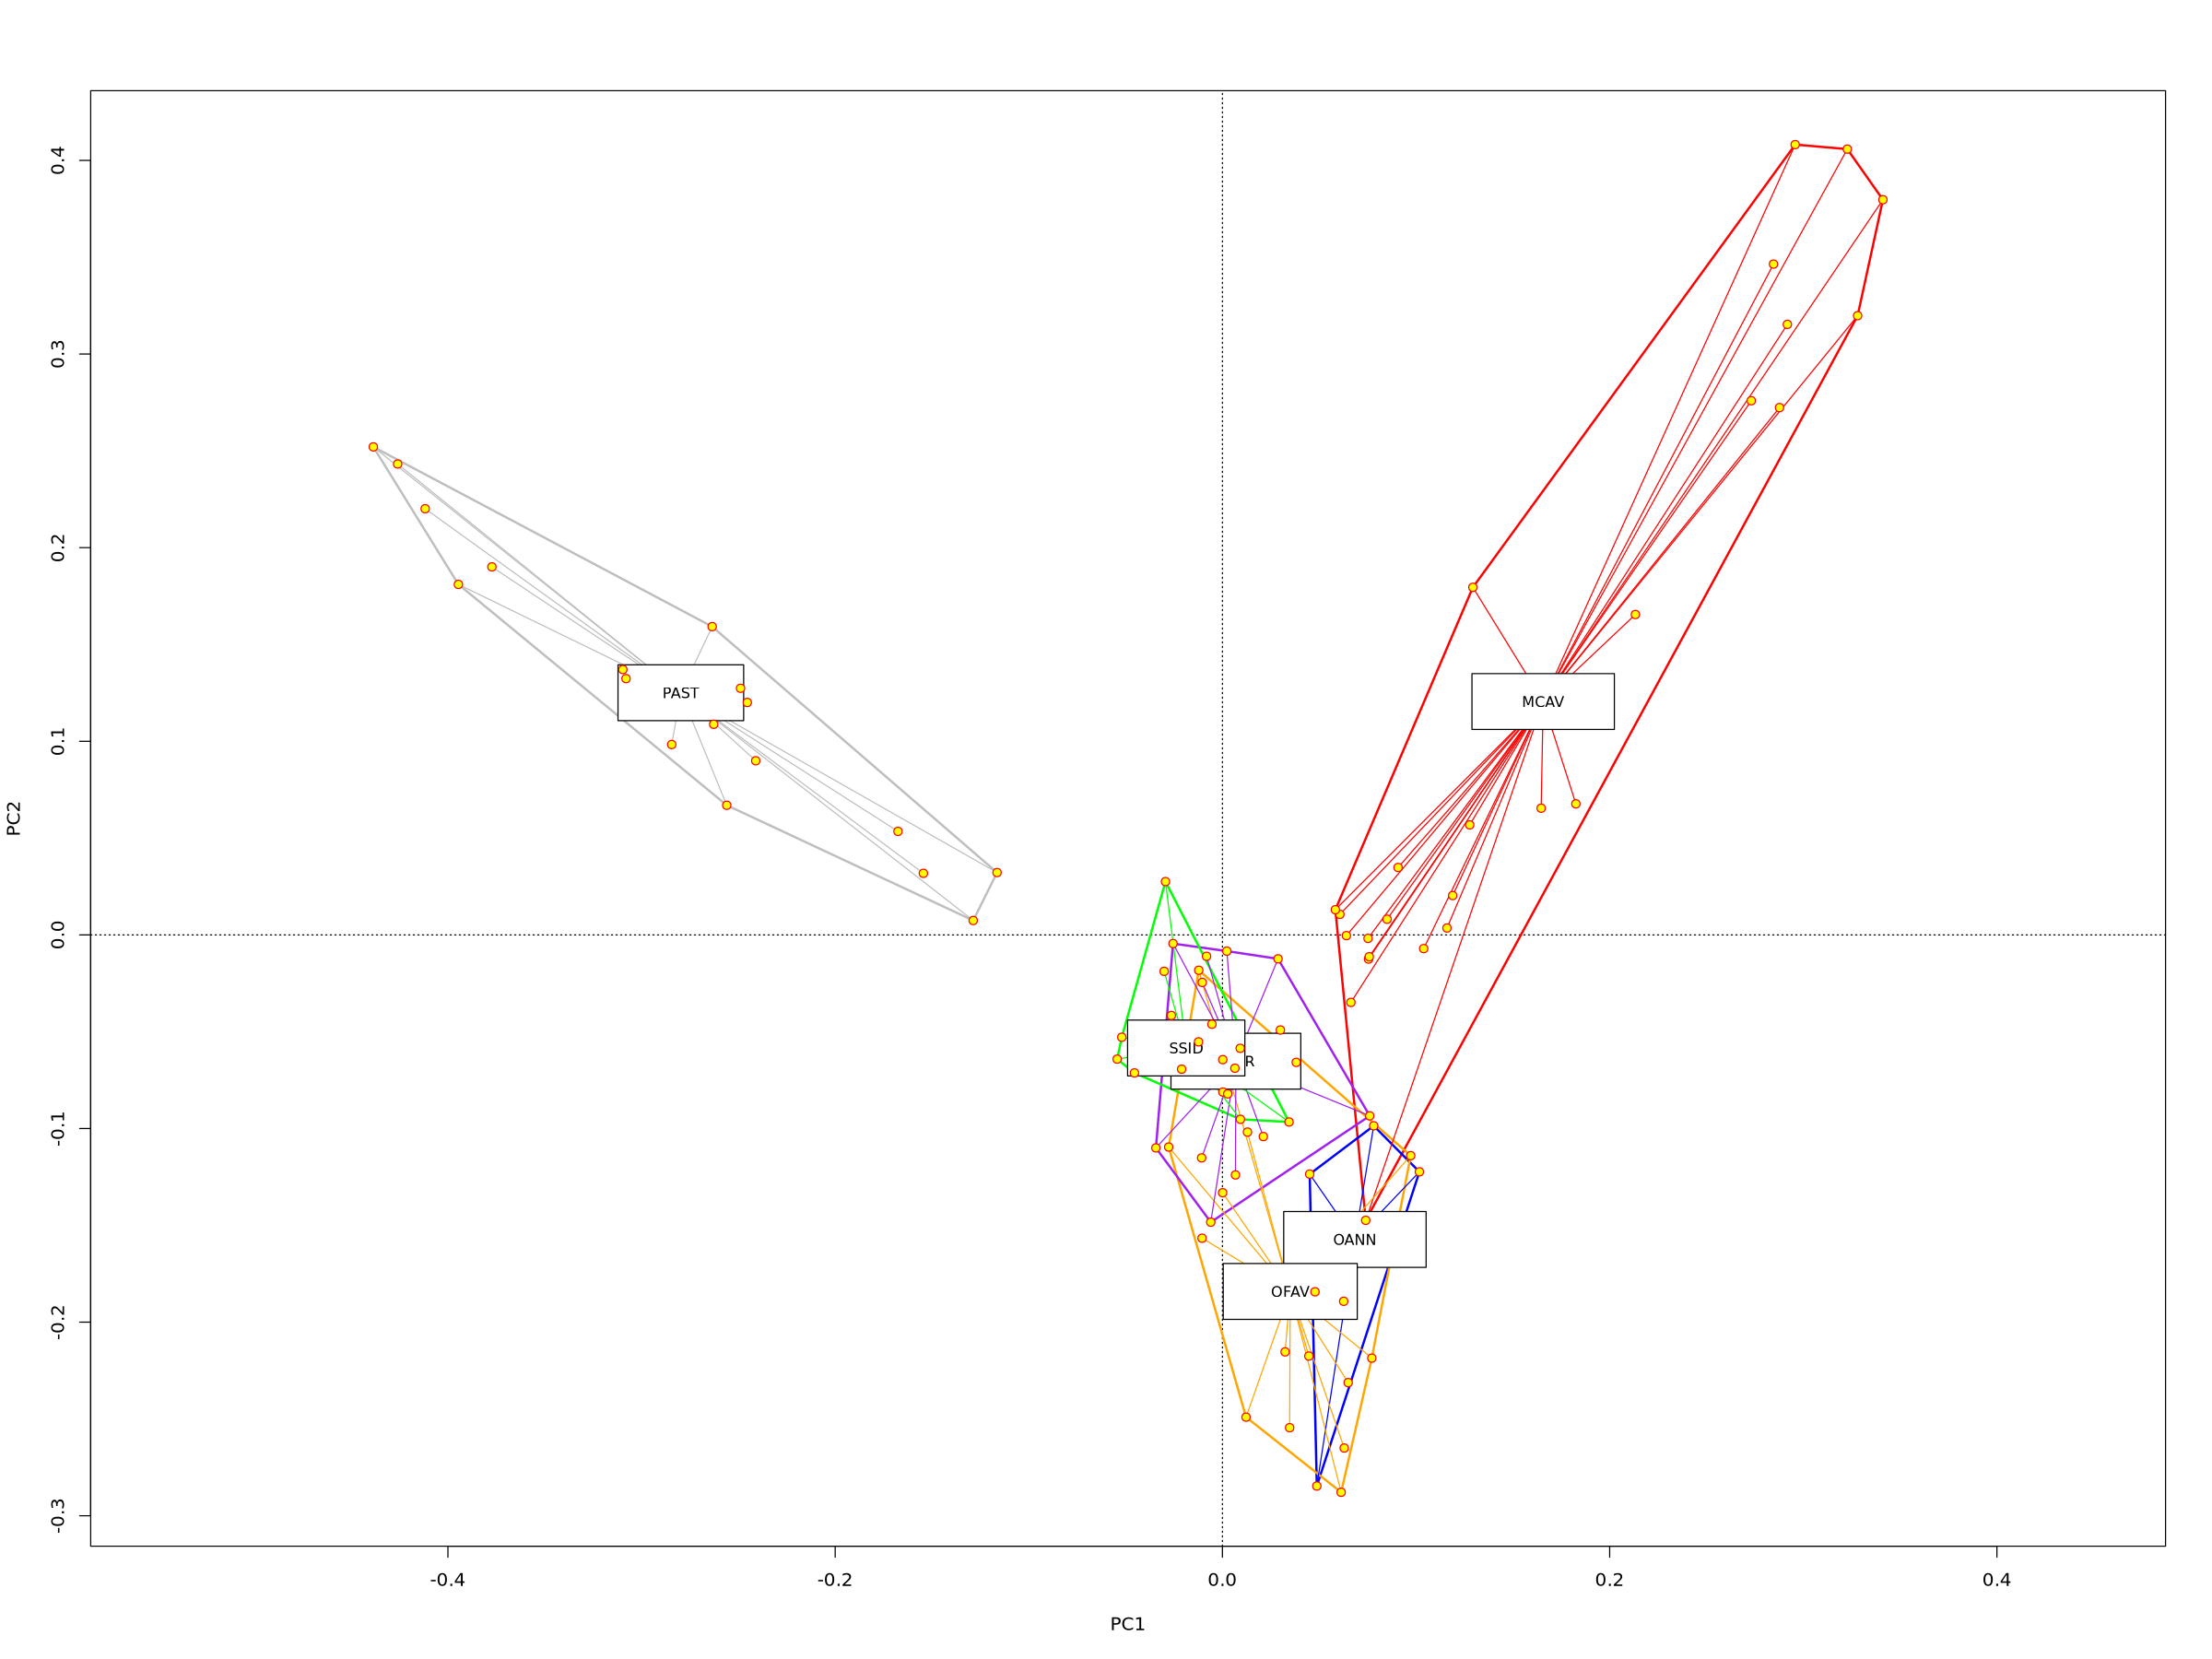

In [67]:
#by species 
disp <- "sites" 
scl <- "symmetric" 

#transforming species col from chr to factor 
otu_merged$species <- factor(otu_merged$species)
# PCA via rda()
pca_mod <- rda(ord)
#color points
# Color vector
col_vec <-c("red", "blue", "orange", "grey", "purple", "green")
cols <- col_vec[otu_merged$species]
plot(pca_mod, type = "n", scaling = scl, display = disp) 
ordihull(pca_mod, groups = otu_merged$species, col = col_vec, scaling = scl, lwd = 2) 
ordispider(pca_mod, groups = otu_merged$species, col = col_vec, scaling = scl, label = TRUE) 
points(pca_mod, display = disp, scaling = scl, pch = 21, col = "red", bg = "yellow")

### but how much variance is explained by pc1 and pc2?
- pretty much its not much

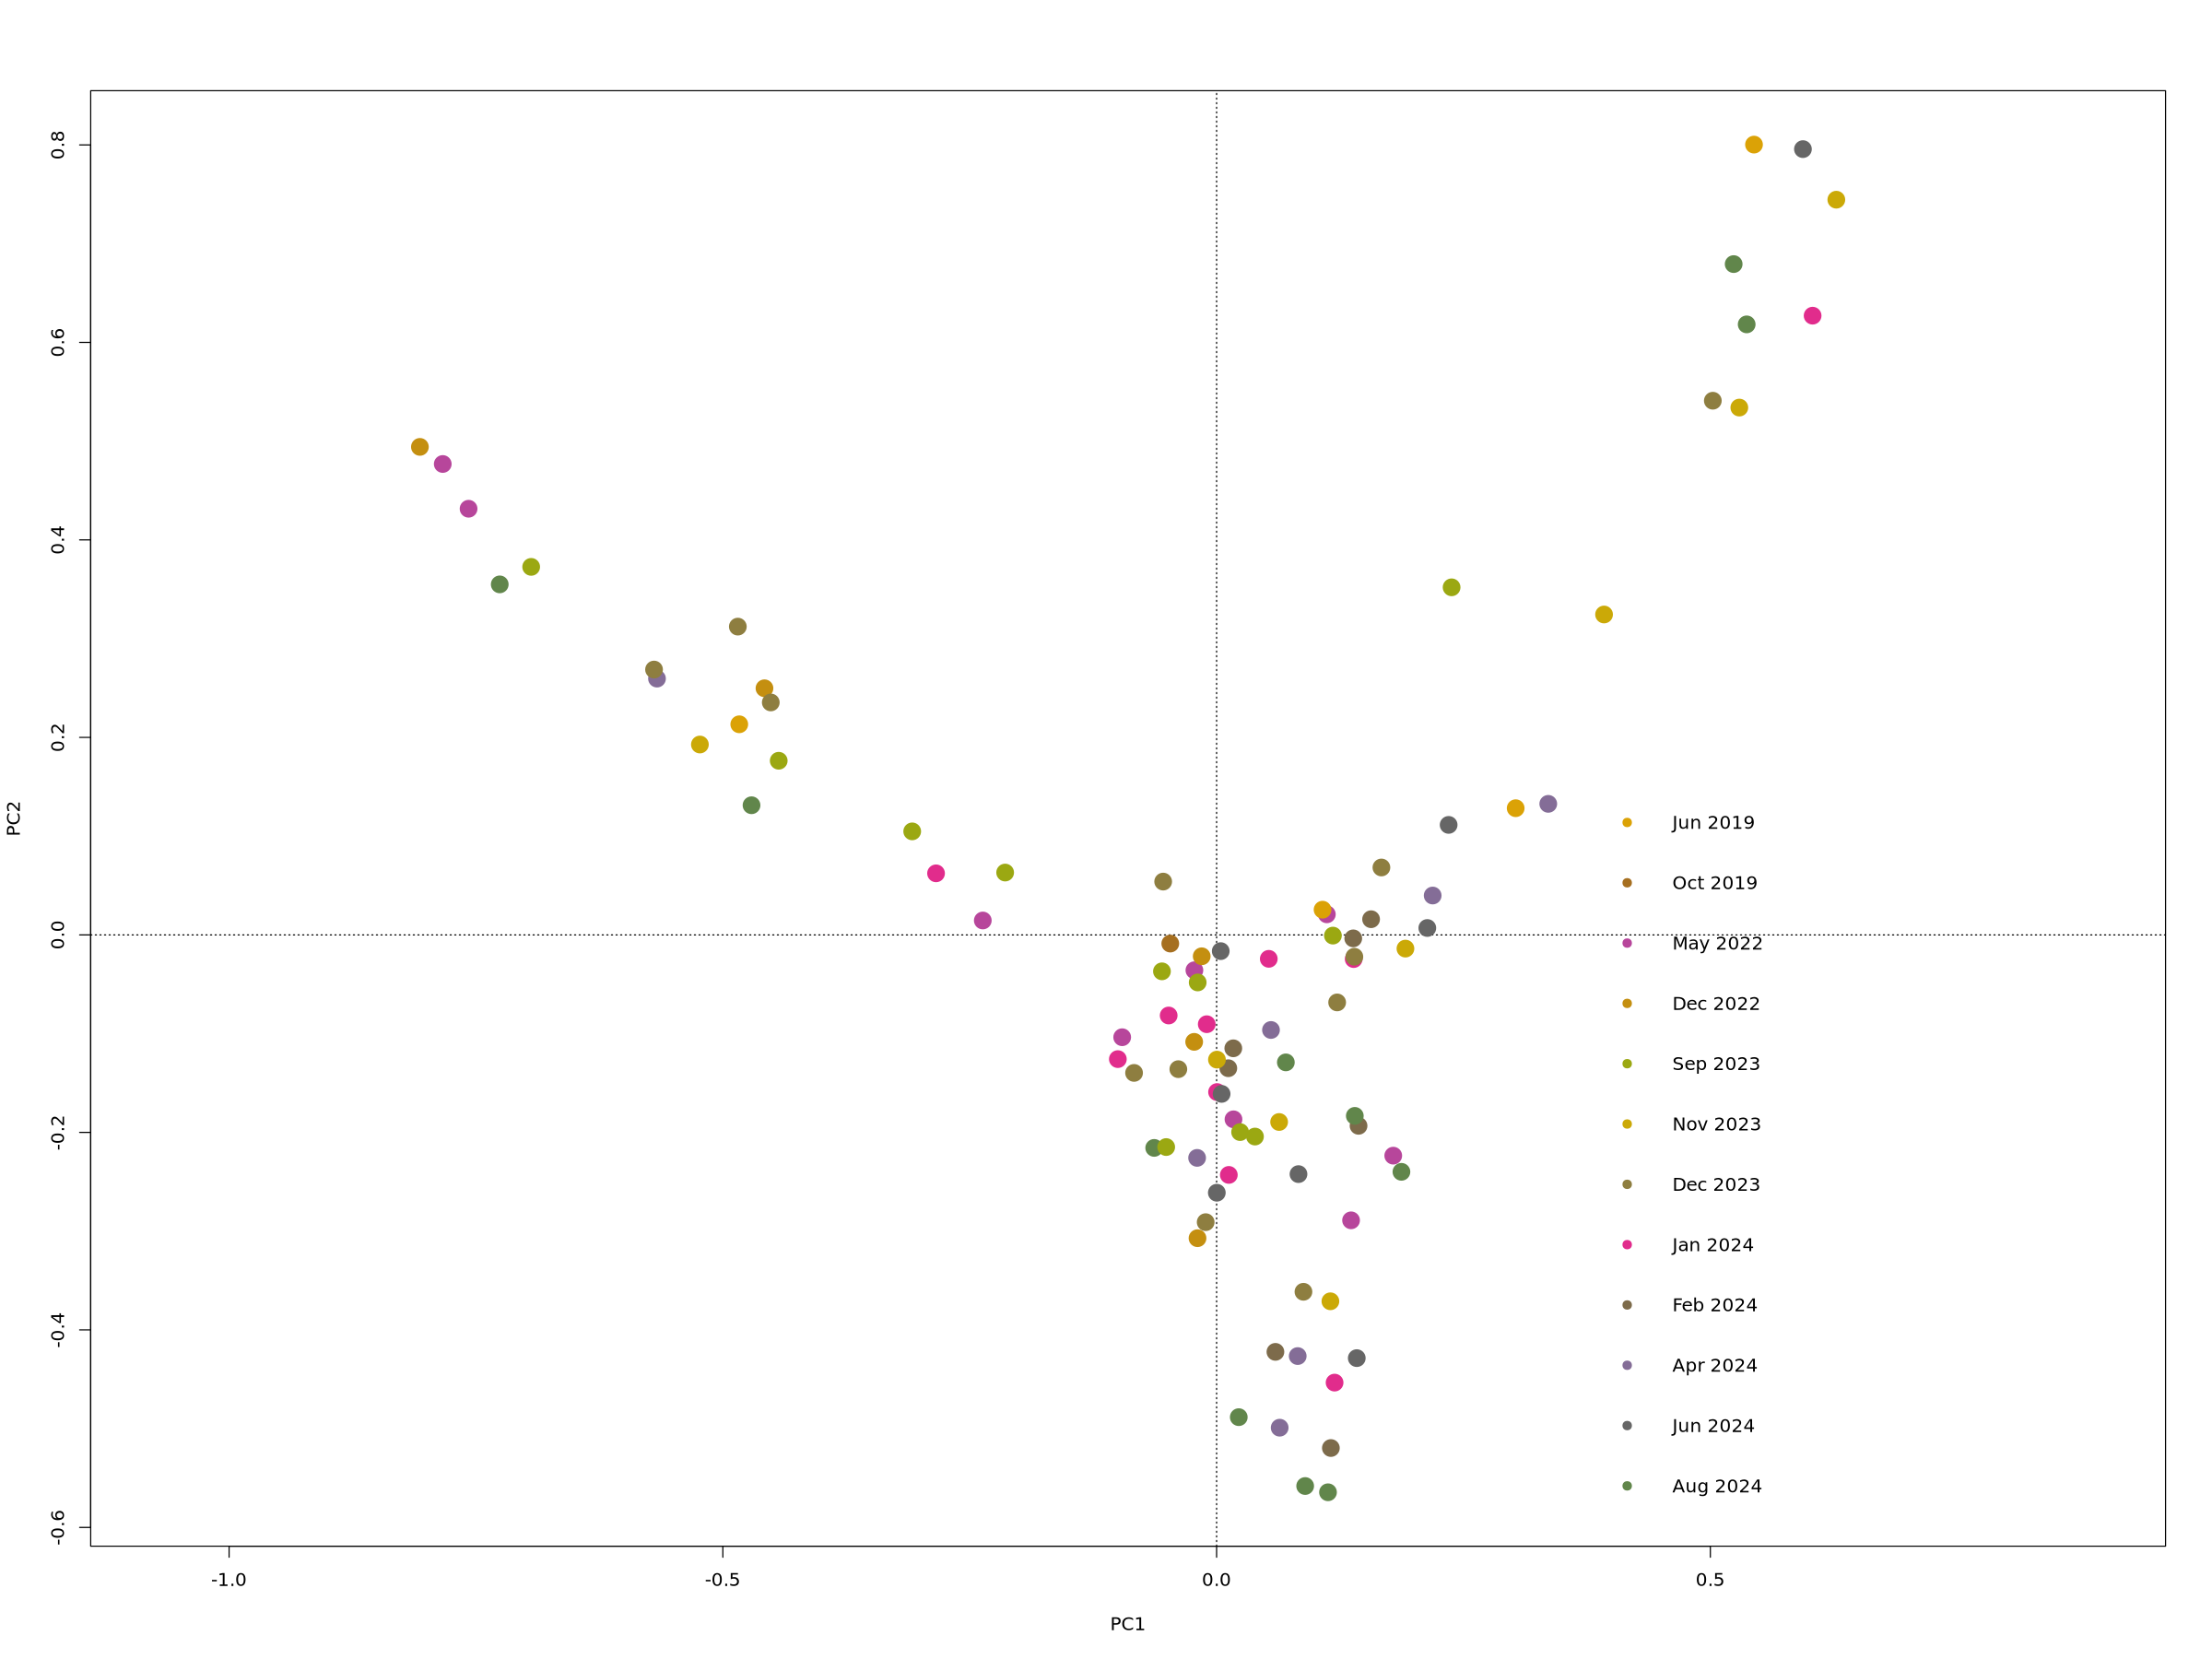

In [66]:
#transforming MonthYear col from chr to factor 
otu_merged$MonthYear <- factor(otu_merged$MonthYear)
# PCA via rda()
pca_my <- rda(ord)
#color points
# Color vector
col_my <-colorRampPalette(brewer.pal(8, "Dark2"))(20)
# Generate a random set of colors 
    col_my <- sample(col_my, 20)
cols <- col_my[otu_merged$MonthYear]

#plot
plot(pca_my, type = "n", scaling = 2, display = "sites")

points(pca_my, display = "sites", scaling = 2,
       pch = 19, col = cols, cex = 2)

legend("bottomright",
       legend = levels(otu_merged$MonthYear),
       bty = "n",
       col = col_my,
       pch = 19)

## clusters based on dendogram

In [13]:
dij <- vegdist(otu_nochlo) ## bray curtis dissimilarity
clu <- hclust(dij, method = "average")
# 2 clusters bc I know Date_16S is already driving into 2 clusters
grp <- cutree(clu, 8)

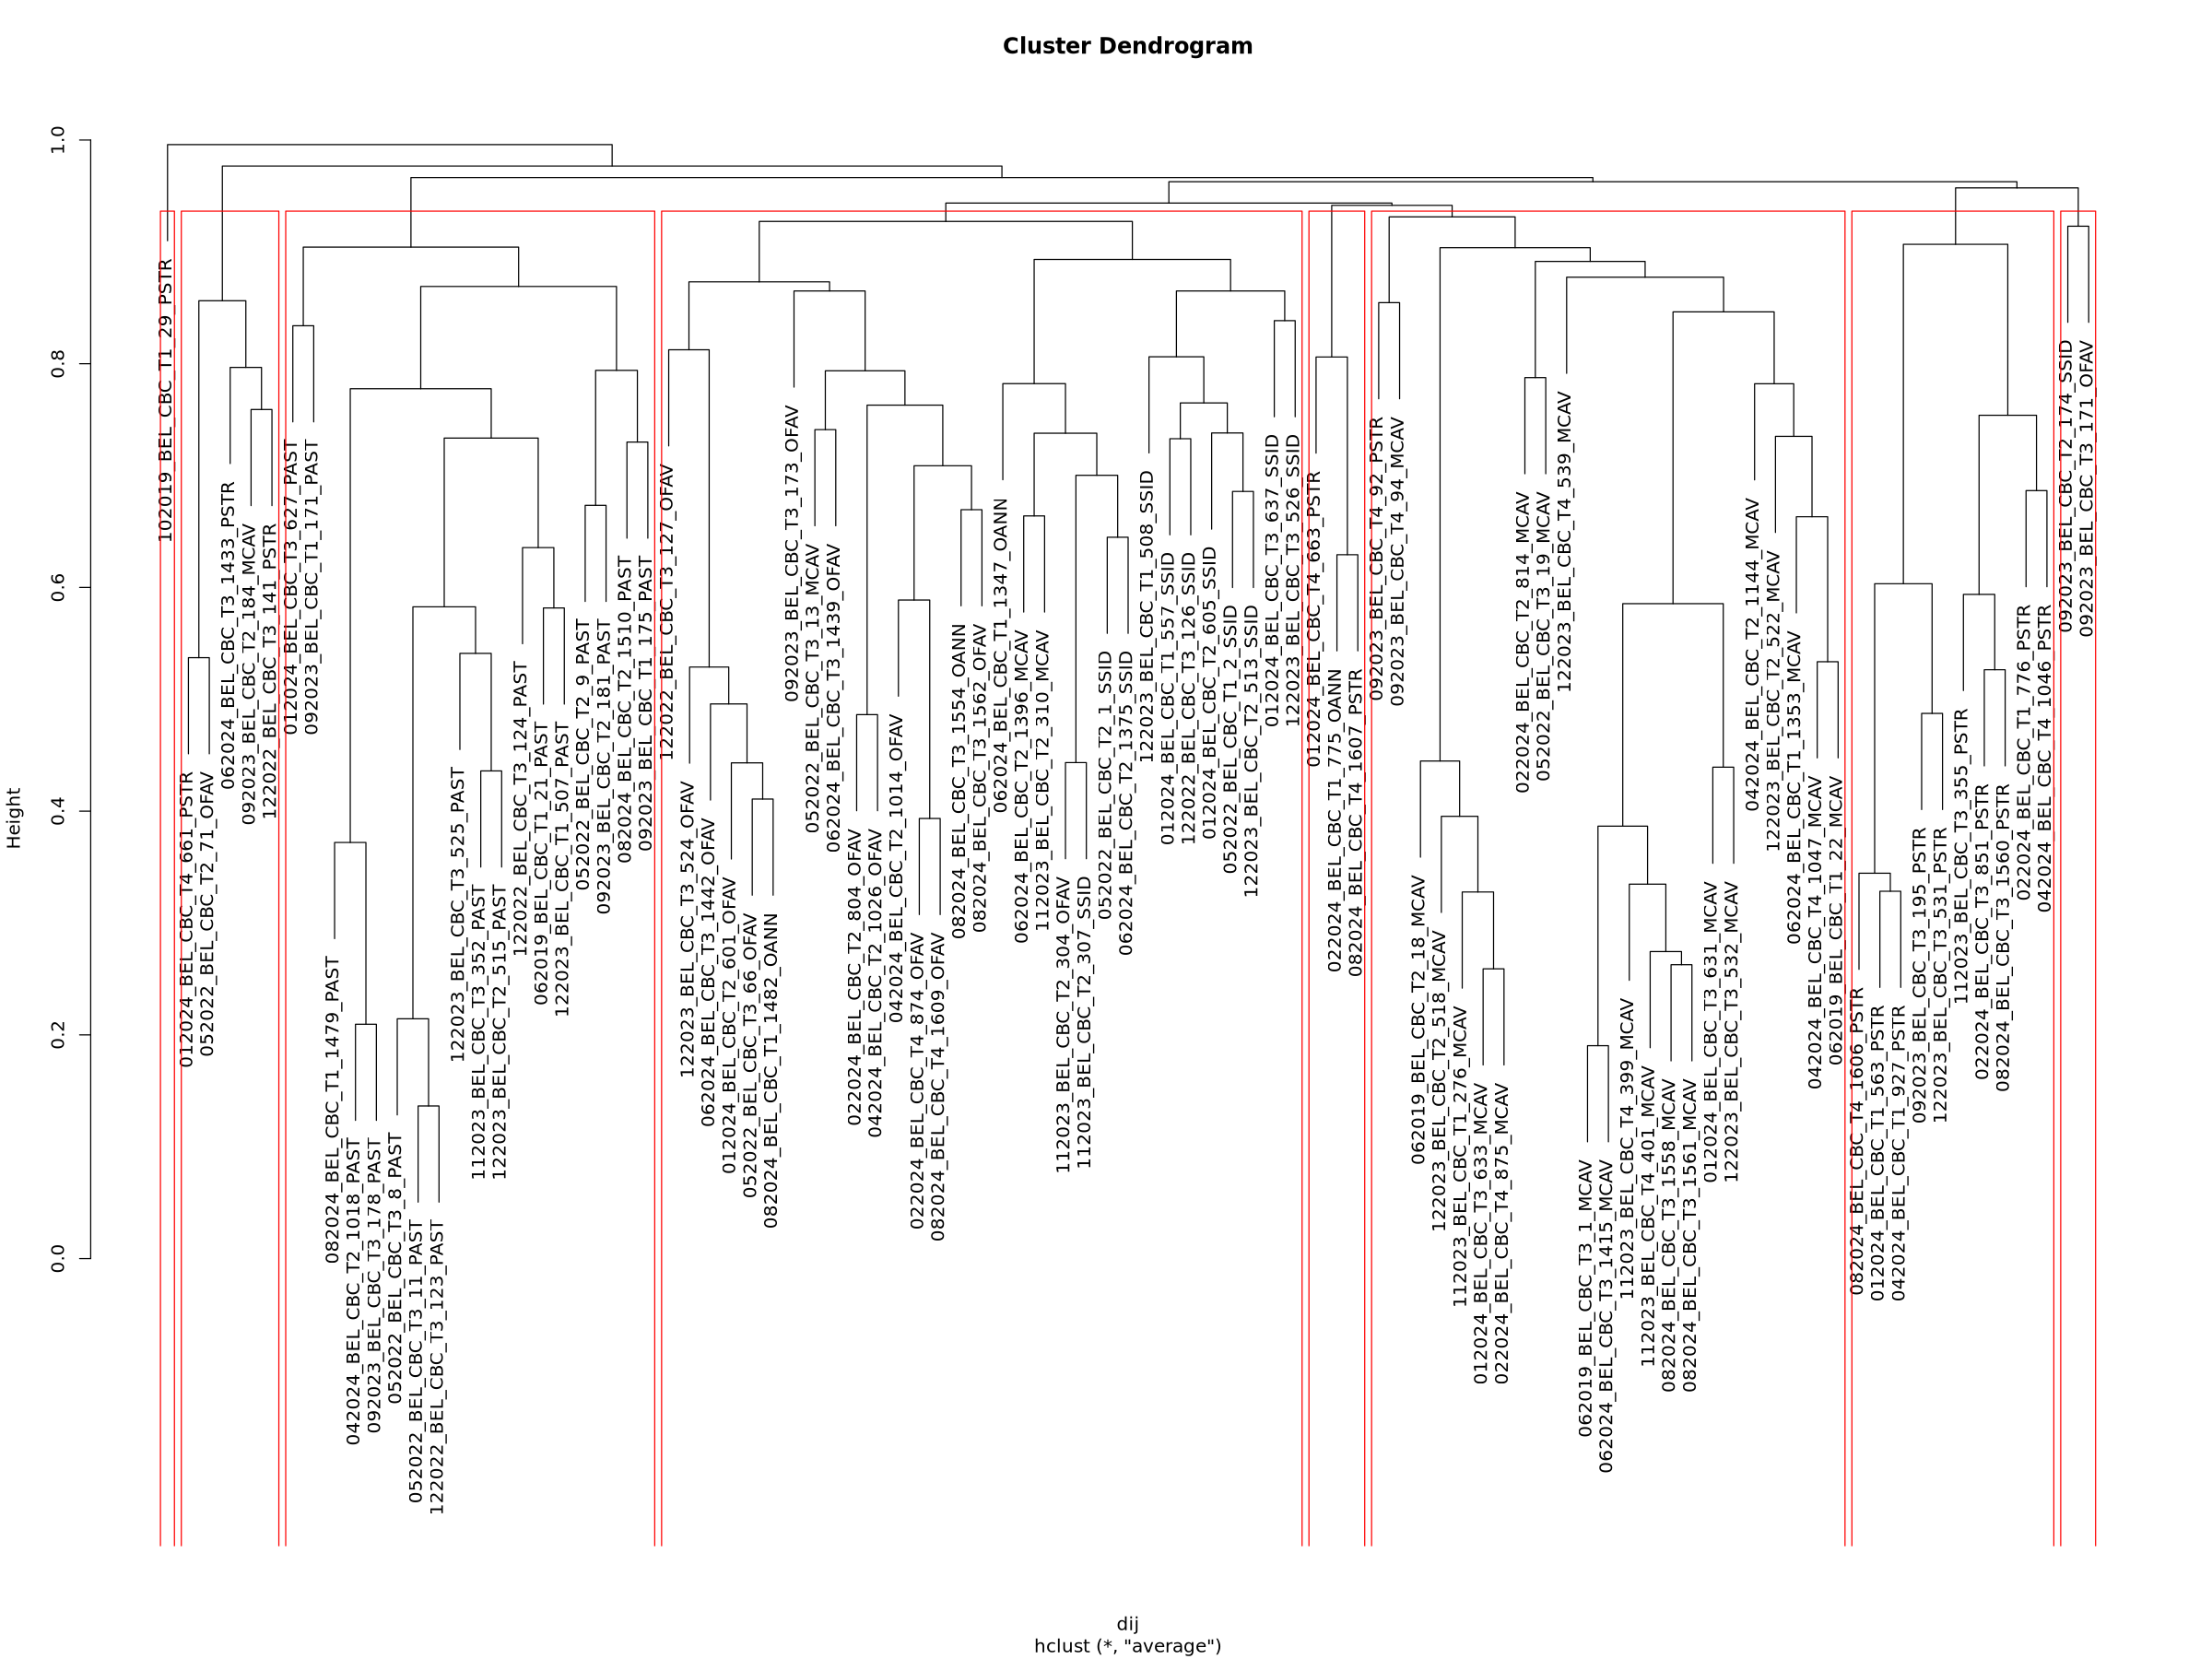

In [16]:
# visualizing the parent dendogram
plot(clu); rect.hclust(clu, k=8, border="red")

In [17]:
# If you don`t provide a dissimilarity matrix, metaMDS automatically applies Bray-Curtis. So in our case, the results would have to be the same
nmds <- metaMDS(otu_nochlo, k = 2, trymax = 100, trace = F)
class(nmds)

[1] "metaMDS" "monoMDS"

In [18]:
# basically trying to turn nmds into a dataframe
#1. Extract only the samples from nmds
nmds_points <- as.data.frame(scores(nmds, display = "sites"))
# 2. Add sample IDs 
nmds_points$SampleID <- rownames(nmds_points)

In [33]:
# Convert to data frame for safe merging
#remember grp is what I named the parent clusters when I split them for the red dendogram
clusters <- data.frame(
  SampleID = names(grp),
  cluster = factor(grp)
)
# Merge parent cluster info with NMDS points
nmds_points <- merge(nmds_points, clusters, by = "SampleID")

In [34]:
class(nmds)
class(sample_clean)
head(nmds_points)

[1] "metaMDS" "monoMDS"

[1] "data.frame"

,SampleID,NMDS1,NMDS2,NMDS3,NMDS4,cluster
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,012024_BEL_CBC_T1_557_SSID,-0.05649277,-0.090893285,-0.005216009,-0.065444415,1
2,012024_BEL_CBC_T1_563_PSTR,0.23358693,-0.164927281,-0.041462083,-0.199568993,2
3,012024_BEL_CBC_T2_601_OFAV,0.05356890,0.168178283,-0.068567912,-0.142868487,1
4,012024_BEL_CBC_T3_631_MCAV,0.23389337,0.101894828,-0.067880771,-0.115330249,1
5,012024_BEL_CBC_T3_633_MCAV,0.07224464,0.007515843,-0.206715999,-0.004186982,1
6,012024_BEL_CBC_T3_637_SSID,0.23056365,-0.121352801,-0.032906253,0.004585615,1


In [35]:
#merge nmds points with sample metadata
# easy merging by making sure sample metadata has a $SampleID column to match nmds_points 
sample_clean$SampleID <- rownames(sample_clean) 
# Merge using new SampleID column
nmds_merged <- merge(nmds_points, sample_clean, by = "SampleID")

In [36]:
any(duplicated(colnames(nmds_merged)))
colnames(nmds_merged)[duplicated(colnames(nmds_merged))]
#should be false

[1] FALSE

character(0)

In [41]:
#wider plots
#making plots small 
options(repr.plot.width = 30, repr.plot.height = 20)
#color assignment
mycolors= colorRampPalette(brewer.pal(8, "Dark2"))(20)
mycolors <- sample(mycolors, 20)

Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Too few points to calculate an ellipse
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_path()`).”


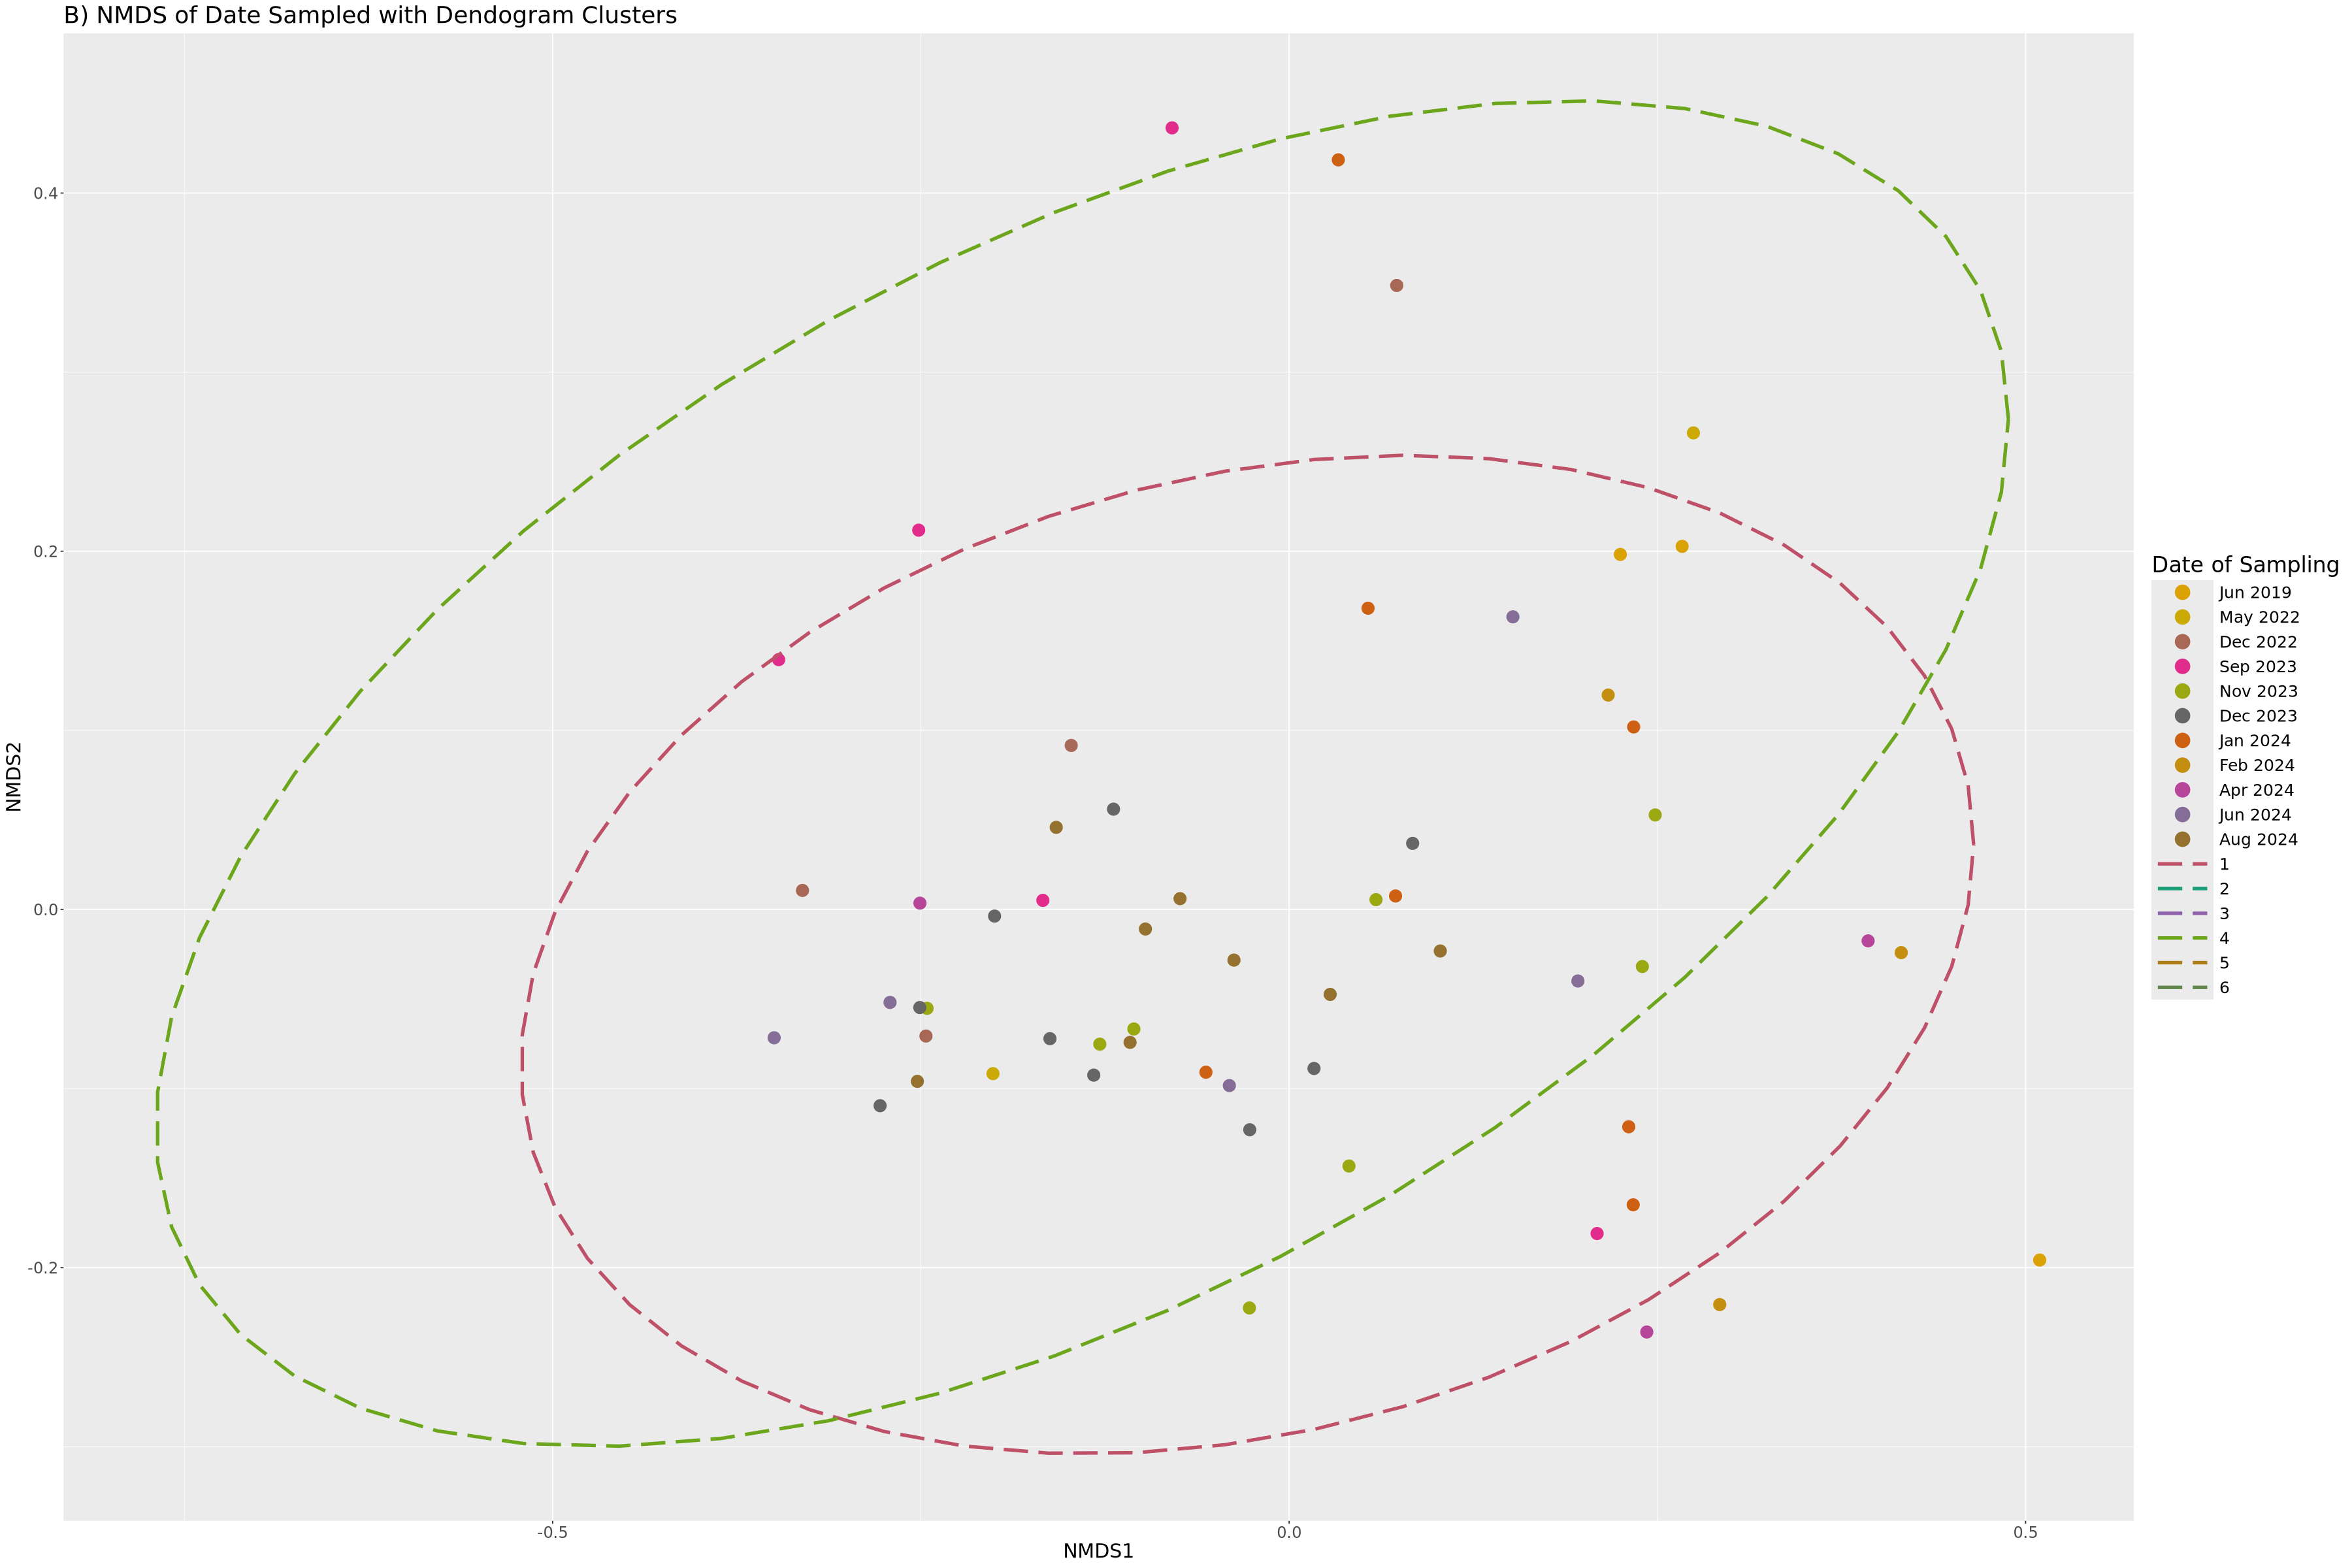

In [42]:
### no longer have to facet by parent cluster yippee

species_cluster <- ggplot(nmds_merged, aes(NMDS1, NMDS2)) +
  # Points: color by MonthYear
  geom_point(aes(color = MonthYear), size = 5, alpha = 1) +
  guides(col = guide_legend(order = 1),
          shape = guide_legend(order = 2)) +
 theme(text = element_text(size = 20)) +
  #Ellipsoids: outline by Subgroup (dashed, same color palette)
stat_ellipse(
  aes(group = cluster, color = cluster),
  type = "norm",
  level = 0.95,
  linetype = "longdash",
  linewidth = 1.5,     # thicker lines
  alpha = 1            # fully opaque
) +
  
  #Use the same color palette for both
scale_color_manual(values = mycolors, drop = TRUE) +
  
  #Axis labels and theme
  labs(x = "NMDS1", y = "NMDS2", color = "Date of Sampling", title = 'B) NMDS of Date Sampled with Dendogram Clusters')+
theme(
  legend.position = "right", 
  legend.title = element_text(size = 20),
  legend.text = element_text(size = 15),
  text = element_text(size = 18),
  legend.key.width = unit(2, "cm"),     # make the legend keys wider
  legend.key.height = unit(0.8, "cm")   # make them taller
) +
guides(color = guide_legend(override.aes = list(size = 6))) 
species_cluster

In [44]:
# Find the convex hull of the points being plotted
hull <- nmds_merged %>%
  slice(chull(NMDS1, NMDS2))

# Define the scatterplot
p <- ggplot(nmds_merged, aes(NMDS1, NMDS2)) + geom_point(shape = 21) + 
 geom_polygon(data = hull, alpha = 0.5)

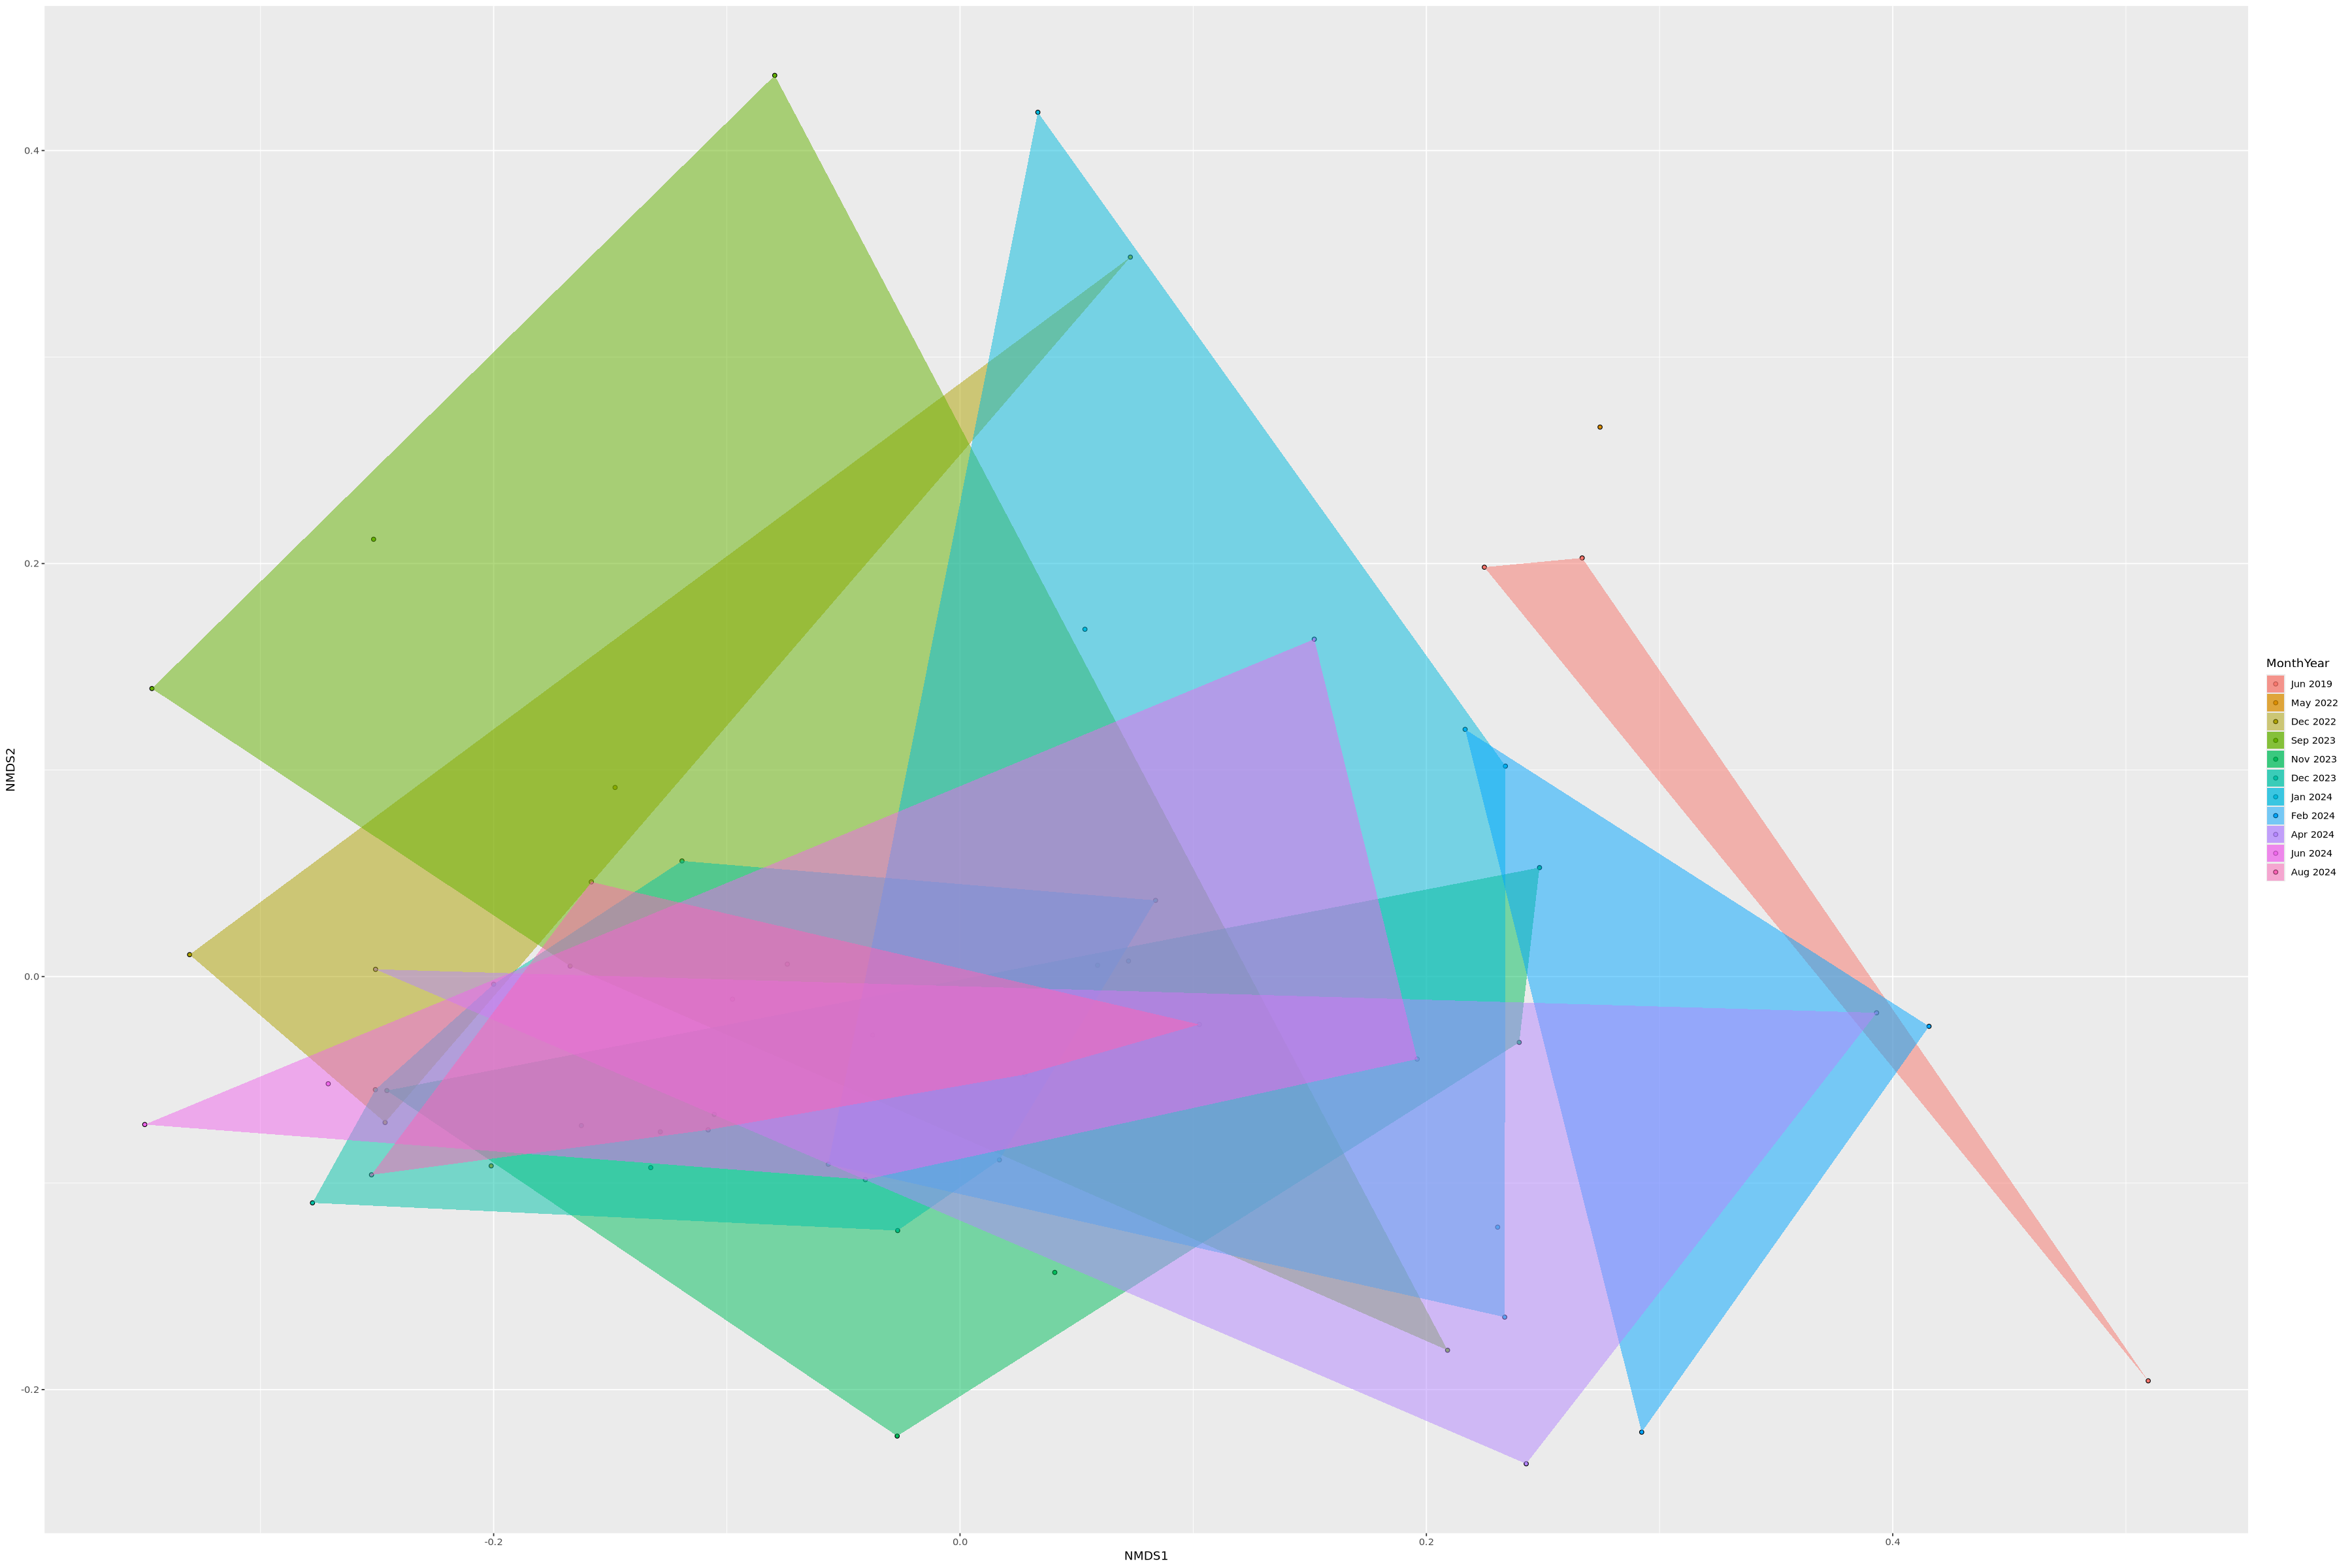

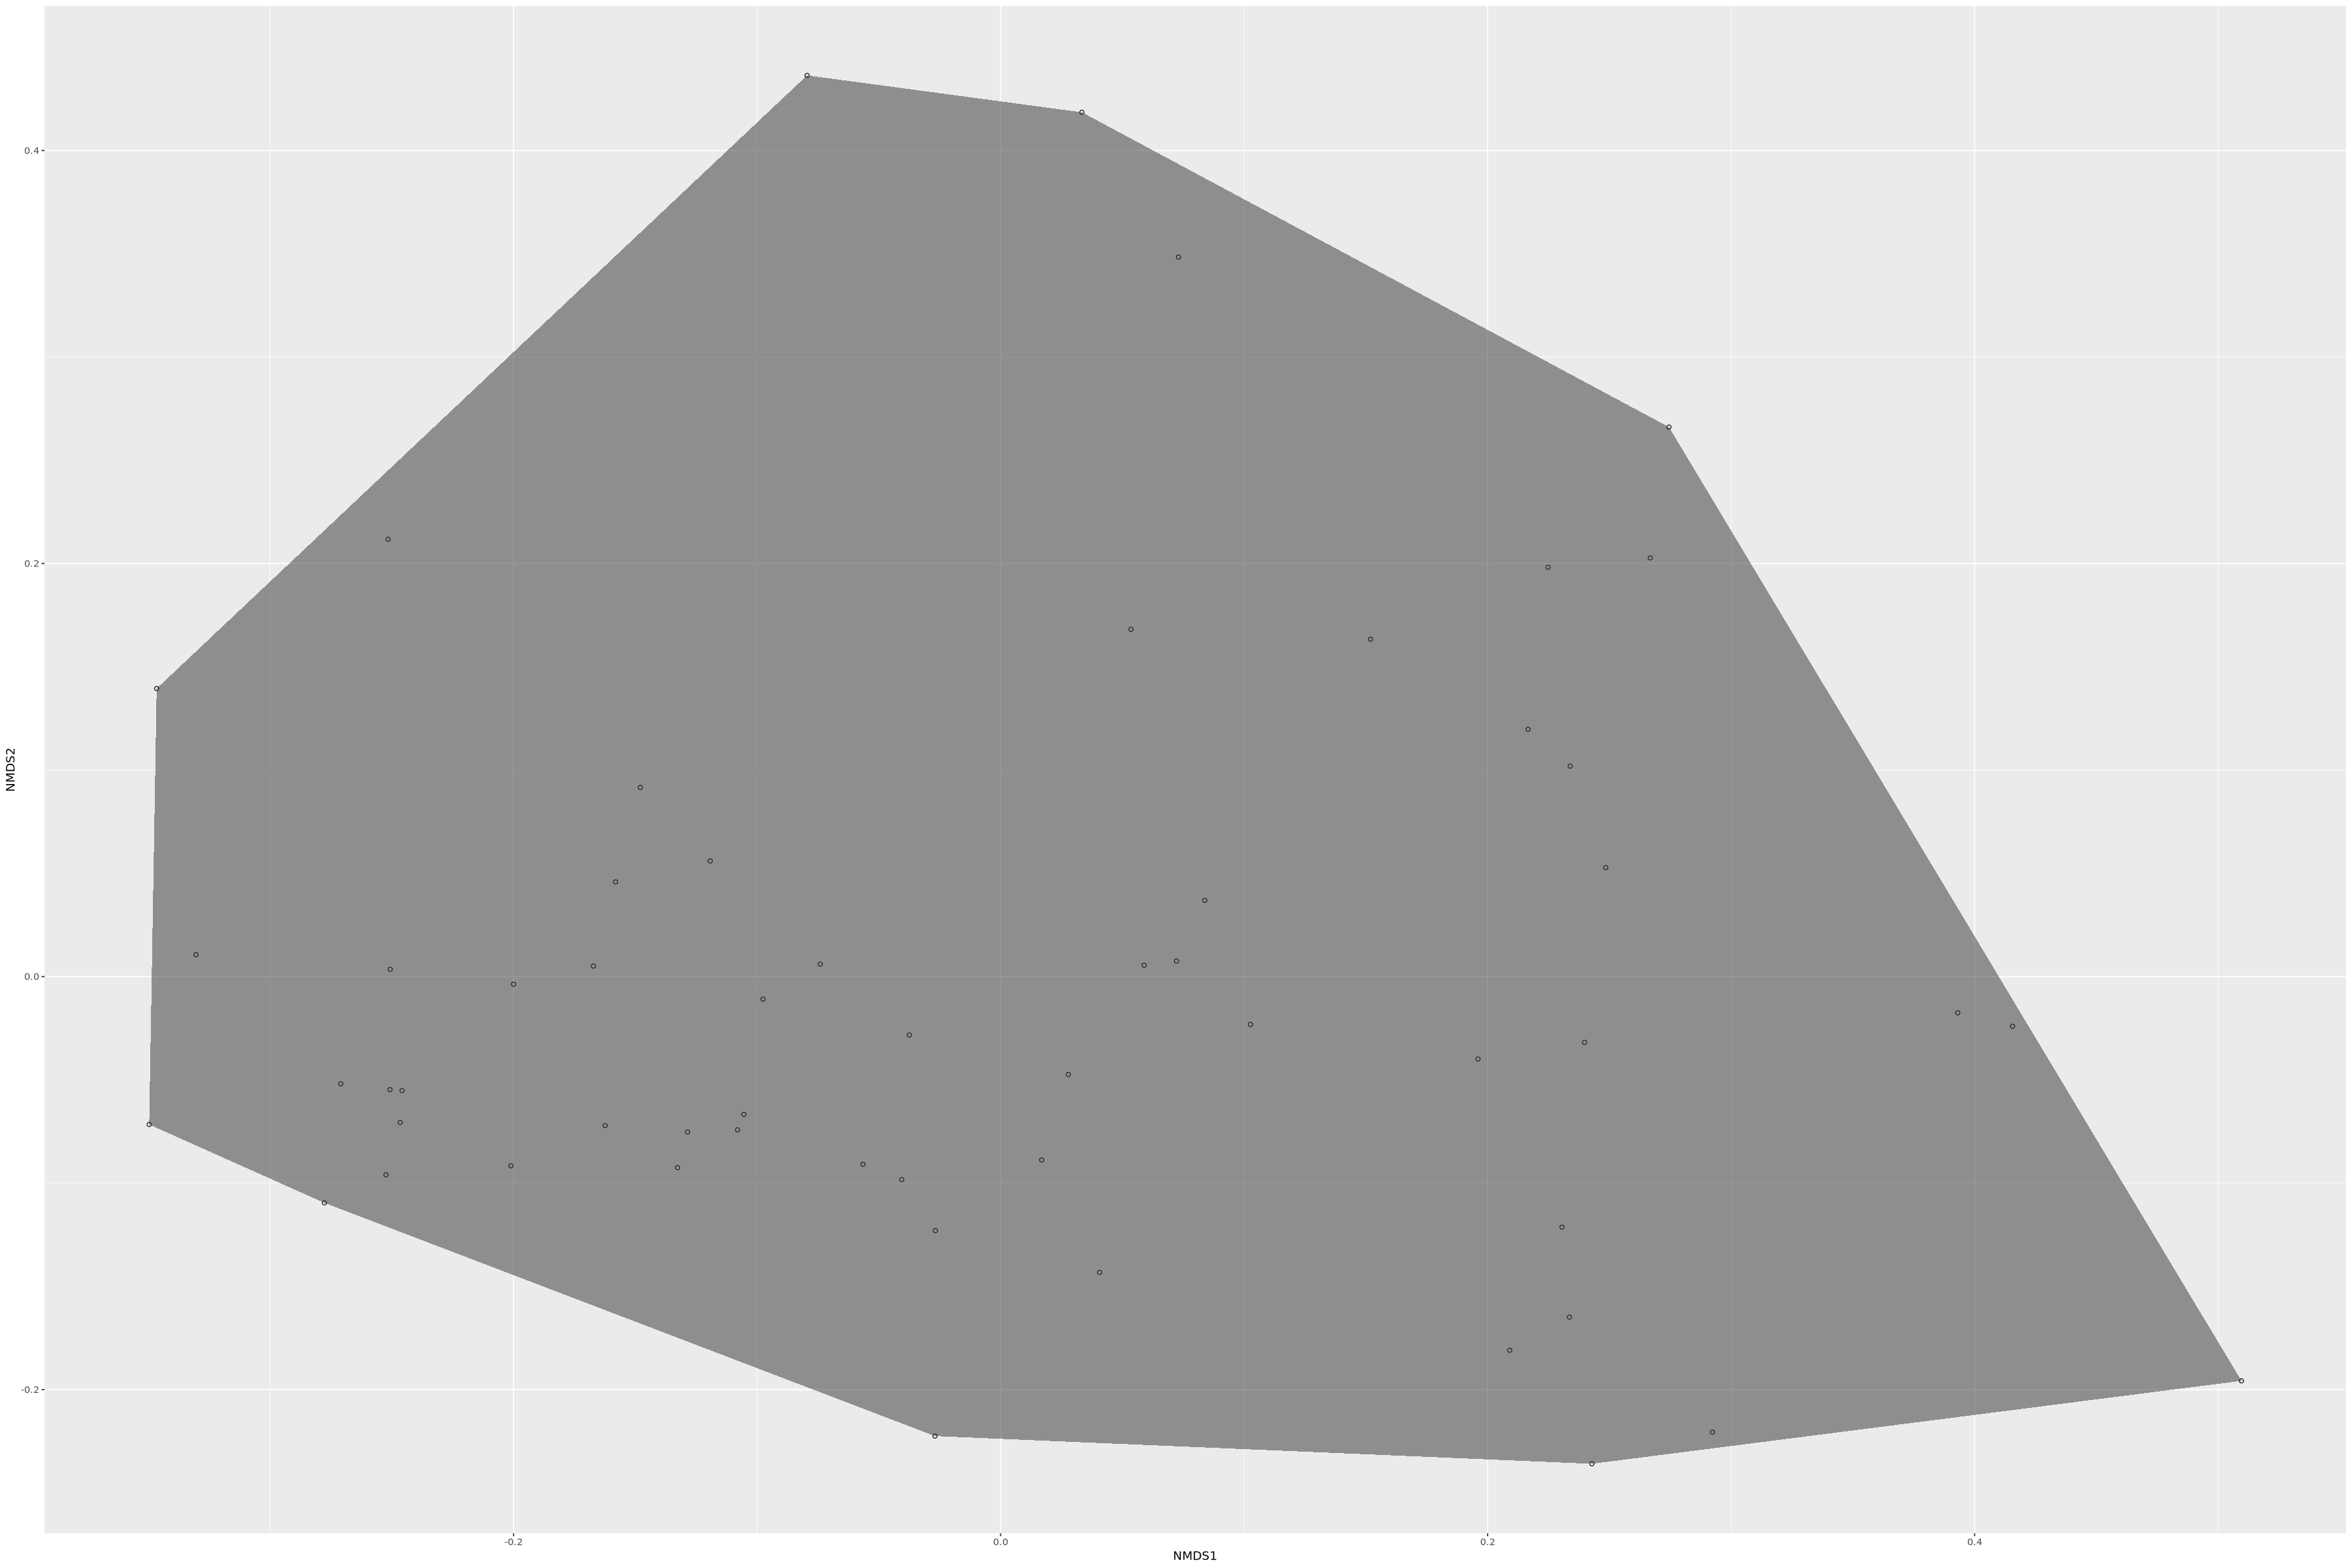

In [46]:
# Calculate the hulls for each group
hull_MonthYear <- nmds_merged %>%
  group_by(MonthYear) %>%
  slice(chull(NMDS1, NMDS2))

# Update the plot with a fill group, and overlay the new hulls
p + aes(fill = MonthYear) + geom_polygon(data = hull_MonthYear, alpha = 0.5)

p

## heatmap with dendogram